# Leap Frog Time Stepping for Yang Mills

See work of Christiansen, Winther
https://epubs.siam.org/doi/pdf/10.1137/040616887

Srinath Bulusu, Joachim Schöberl

In [1]:
from ngsolve import *

from ngsolve.meshes import *

from ngsolve.solvers import *
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt

from su2_yangmills import *

import numpy as np
import json

In [2]:
ne=40
#mesh = MakeStructured2DMesh(quads=False, nx=ne, ny=ne, periodic_x=True, periodic_y=True)
mesh = MakeStructured2DMesh(quads=True, nx=ne, ny=ne, periodic_x=True, periodic_y=True)
#mesh = MakeStructured2DMesh(quads=False, nx=ne, ny=ne, periodic_x=False, periodic_y=False)
#Draw(mesh)

Function spaces of Interest are Lie algebra valued p-forms $\Lambda^p(M,\mathfrak{g})$. In two dimensions $p=0,1,2$

The Lie algebra $\mathfrak{g} = su(2)$ can be spanned by three basis vectors (Pauli matrices $\sigma_k$ for example). We will from now on only work with coefficients in the basis $\frac{1}{2i} \sigma_k$, hence $\mathbb{R}^3$-valued p-forms $\Lambda^p(M,\mathbb{R}^3)$. The advantage of this basis, is that the Lie Bracket corresponds to the cross product of coefficients!

In [3]:
order=6
fesC = Periodic(L2(mesh, order=order-1))**3 # for su2 charge
fesA = Periodic(HCurl(mesh, order=order))**3 # for su2 gauge potential
fesAz = Periodic(H1(mesh, order=order))**3 # for su2 gauge potential z component
fesA3D = fesA*fesAz
fesA3DC = fesA3D*fesC

The connection is a map $\mathrm{d}_A: \Lambda^p(M,\mathfrak{g}) \rightarrow \Lambda^{p+1}(M,\mathfrak{g})$ and acts as $v \mapsto \mathrm{d}_A v := \mathrm{d}v + [A \wedge v]$

The exterior derivative in $\mathbb{R}^2$ can be interpreted as gradient and curl
$H1 \simeq \Lambda^0 \stackrel{\nabla}{\rightarrow} Hc \simeq \Lambda^1 \stackrel{\nabla \times}{\rightarrow} L2 \simeq \Lambda^2$

The wedge Bracket $[A \wedge B]$ is the linear extension of $[\mathrm{d}x^\mu \otimes \sigma_k \wedge \mathrm{d}x^\nu \otimes \sigma_l] = \mathrm{d}x^\mu \wedge \mathrm{d}x^\nu \otimes [\sigma_k, \sigma_l]$

The Lie Bracket cna be expressed in terms of structure constants $[\sigma_k, \sigma_l] = f_{klm} \sigma_m$ which in the case of $su(2)$ are the fully antisymmetric Levi Civita symbol $f_{klm}=\epsilon_{klm}$, and we can use the $\mathbb{R}^3$-Cross product for coefficients.

the inner product of two basis matrices is $\langle \sigma_k, \sigma_l \rangle = \mathrm{Tr}(\sigma_k \sigma_l^\top)$ which in the case of $su(2)$ is $\langle \sigma_k, \sigma_l \rangle = \delta_{kl}$, and we can use the $\mathbb{R}^3$-Inner Product for coefficients.

In [4]:
A, Az = fesA3D.TrialFunction()
E, Ez = fesA3D.TrialFunction()
B, Bz = fesA3D.TrialFunction()

Ap, Azp = fesA3D.TestFunction()
Ep, Ezp = fesA3D.TestFunction()
Bp, Bzp = fesA3D.TestFunction()

C = fesC.TrialFunction()
Cp = fesC.TestFunction()


gfA3D = GridFunction(fesA3D)
gfE3D = GridFunction(fesA3D)
gfC = GridFunction(fesC)
gfB3D = GridFunction(fesA3D)

gfA3Dg = GridFunction(fesA3D)
gfE3Dg = GridFunction(fesA3D)
gfCg = GridFunction(fesC)
gfB3Dg = GridFunction(fesA3D)

In [5]:
# matrices for E-A leapfrog time stepping
m = BilinearForm(fesA3D)
m += LieInnerProduct(E,Ep)*dx
m += LieInnerProduct(Ez,Ezp)*dx
#m += LieInnerProduct(E3D,E3Dp)*dx

m.Assemble()
minv = m.mat.Inverse(fesA3D.FreeDofs(), inverse="sparsecholesky")

covdiv_F = BilinearForm(fesA3D, nonassemble=True)
curl_A_2Dz_CF = curl_A_2Dz(A, Az, Ep, Ezp)
F_A_2Dz_CF = F_A_2Dz(A, Az)
covdiv_F += InnerProduct(F_A_2Dz_CF, curl_A_2Dz_CF)*dx(bonus_intorder=2*order)


covdiv = BilinearForm(fesA3D, nonassemble=True)
curl_A_Ep_CF = curl_A_2Dz(gfA3D.components[0], gfA3D.components[1], Ep, Ezp)
# TODO: B in Hdiv?
covdiv += InnerProduct(gVector_3DCF(B,Bz), curl_A_Ep_CF)*dx(bonus_intorder=order)

covgrad = BilinearForm(trialspace=fesC, testspace=fesA3D, nonassemble=True)
grad_A_2Dz_C_CF = grad_A_2Dz(gfA3D.components[0], gfA3D.components[1], C)
covgrad += InnerProduct(grad_A_2Dz_C_CF, gVector_3DCF(Ep,Ezp))*dx(bonus_intorder=order)



curv = BilinearForm(fesA3D, nonassemble=True)
F_A_2Dz_CF = F_A_2Dz(A, Az)
curv += InnerProduct(F_A_2Dz_CF, gVector_3DCF(Bp, Bzp))*dx(bonus_intorder=order)



covdivg = BilinearForm(fesA3D, nonassemble=True)
curl_A_Ep_CFg = curl_A_2Dz(gfA3Dg.components[0], gfA3Dg.components[1], Ep, Ezp)
covdivg += InnerProduct(gVector_3DCF(B,Bz), curl_A_Ep_CFg)*dx(bonus_intorder=order)

covgradg = BilinearForm(trialspace=fesC, testspace=fesA3D, nonassemble=True)
grad_A_2Dz_C_CFg = grad_A_2Dz(gfA3Dg.components[0], gfA3Dg.components[1], C)
covgradg += InnerProduct(grad_A_2Dz_C_CFg, gVector_3DCF(Ep,Ezp))*dx(bonus_intorder=order)

In [6]:
# matrices for evaluating charge
mC = BilinearForm(fesC)
mC += LieInnerProduct(C,Cp)*dx

mC.Assemble()
mCinv = mC.mat.Inverse(fesC.FreeDofs(), inverse="sparsecholesky")


covdivC = BilinearForm(trialspace=fesA3D, testspace=fesC, nonassemble=True)
grad_A_2Dz_Cp_CF = grad_A_2Dz(gfA3D.components[0], gfA3D.components[1], Cp)
covdivC += LieInnerProduct(gVector_3DCF(E,Ez), grad_A_2Dz_Cp_CF)*dx(bonus_intorder=order)

covdivCg = BilinearForm(trialspace=fesA3D, testspace=fesC, nonassemble=True)
grad_A_2Dz_Cp_CFg = grad_A_2Dz(gfA3Dg.components[0], gfA3Dg.components[1], Cp)
covdivCg += LieInnerProduct(gVector_3DCF(E,Ez), grad_A_2Dz_Cp_CFg)*dx(bonus_intorder=order)

Functions transform under gauge transformations $g: M \rightarrow G = SU(2)$ via

$
E \mapsto g E g^{-1}
$

$
A \mapsto g A g^{-1} - \mathrm{d} g g^{-1}
$

For $SU(2)$ some operations can be implemented using quaternions $\mathbb{H}$.

In [7]:
sigma2 = 0.003
mu0 = [0.5, 0.5]
mu1 = [0.7, 0.5]
mu2 = [0.3, 0.5]
mu3 = [0.5, 0.3]

E_init_CF = CF( (0,0 ,0,0 ,0,0) ).Reshape((3,2))
#Ez_init_CF = CF( (gaussxyper([0.5, 0.5], 2*sigma2) ,0 ,0) ).Reshape((3,1))
#Ez_init_CF = CF( (sin(4*pi*x) ,0 ,0) ).Reshape((3,1))
#Ez_init_CF = CF( (sin(4*pi*x + 4*pi*y) ,0 ,0) ).Reshape((3,1))
#Ez_init_CF = CF( (gaussxyper(mu1, sigma2) ,gaussxyper(mu2, sigma2) ,0) ).Reshape((3,1))

#Ez_init_CF = CF( (gaussxyper(mu1, sigma2) + gaussxyper(mu2, sigma2), 0 ,0) ).Reshape((3,1))

scale = 0.001
Ez_init_CF = CF( (gaussxyper(mu1, sigma2) ,gaussxyper(mu2, sigma2) ,0) ).Reshape((3,1))
Ez_init_CF = scale*CF( (gaussxyper(mu1, sigma2) ,gaussxyper(mu2, sigma2) ,0) ).Reshape((3,1))


#Ez_init_CF = CF( (0,0 ,0,0 ,0,0) ).Reshape((3,2))

A_init_CF = CF( (0,0 ,0,0 ,0,0) ).Reshape((3,2))
Az_init_CF = CF( (0 ,0 ,0) ).Reshape((3,1))

# phi*n_k is are the Lie Algebra coefficients in the same basis as E,A ([.,.] becomes Cross!)
#phi_CF = CF( 0.25*pi )

r = lambda mu: [(x-mu[0]),(y-mu[1])]
bubble = lambda mu: 16*(r(mu)[0]+0.5)*(r(mu)[0]+0.5-1)*(r(mu)[1]+0.5)*(r(mu)[1]+0.5-1)
#bubble = lambda mu: 16*(r(mu)[0]-0.5)*(r(mu)[0]-0.5-1)*(r(mu)[1]-0.5)*(r(mu)[1]-0.5-1)

#phi_CF = lambda mu: CF( 0 )
#phi_CF = lambda mu: CF( 0.5*pi )
#phi_CF = lambda mu: CF( 2*pi*r(mu)[1] )
#phi_CF = lambda mu: CF( 0.5*pi*r(mu)[1] )
#phi_CF = lambda mu: CF( 0.5*pi*r(mu)[0] )
#phi_CF = lambda mu: CF( 0.00353*gaussxy(mu1, 7*sigma2) )
#phi_CF = lambda mu: CF( 1 )

# rotate both peaks into the same color space
#phi_CF = lambda mu: CF( IfPos(sin(2*pi*r(mu)[0]), 0.5*pi * (sin(2*pi*r(mu)[0]))**(1./6.), 0.) )

## THIS IS not so SEVERE
#phi_CF = lambda mu: CF( 2*pi*sin(4*pi*r(mu)[1]) )
#phi_CF = lambda mu: CF( 2*pi*sin(4*pi*r(mu)[0]) )
#phi_CF = lambda mu: CF( pi*sin(4*pi*r(mu)[1]) )
#phi_CF = lambda mu: CF( pi*sin(4*pi*r(mu)[0]) )
#phi_CF = lambda mu: CF( 2*pi*sin( 4*pi*r(mu)[0] + 4*pi*r(mu)[1] ) )

## THIS IS SEVERE!!!
#phi_CF = lambda mu: CF( pi*sin( 4*pi*r(mu)[0] + 4*pi*r(mu)[1] ) )

## THIS IS SEVERE!!!
#phi_CF = lambda mu: CF( pi*sin(4*pi*r(mu)[0])*sin(4*pi*r(mu)[1]) )

phi_CF = lambda mu: 0.05*gaussxyper(mu1, sigma2) - 0.05*gaussxyper(mu2, sigma2)

#phi_CF = lambda mu: CF( 2*pi*sin(4*pi*r(mu)[0]) )
#phi_CF = lambda mu: CF( 2*pi*sin( 4*pi*( (r(mu)[0])**2 + (r(mu)[1])**2) )  )

#phi_CF = lambda mu: CF( r(mu)[0]*(r(mu)[0]-1)*r(mu)[1]*(r(mu)[1]-1)*8*pi*sin(8*pi*r(mu)[1]) )
#phi_CF = lambda mu: CF( pi*sin(pi*(y-mu[1]) ) )
#phi_CF = lambda mu: CF( pi*sin(pi*(y-mu[1])+ pi*(x-mu[0])) )
#phi_CF = lambda mu: CF( pi*cos( pi*sqrt((y-mu[1])**2+(x-mu[0])**2) )  )
#phi_CF = lambda mu: CF( pi*cos( pi*sqrt((y-mu[1])**2+(x-mu[0])**2) ) + 0.1*pi*sin(2*pi*y) )
#phi_CF = lambda mu: (1./(6.1*1000))*gaussxy([mu[0],mu[1]], sigma2)
#phi_CF = lambda mu: sin(4*pi*(x-mu[0]))*(1./(6.1*1000))*gaussxy([mu[0],mu[1]], sigma2)

#phi_CF = square_per_func(phi_CF, x0=[0.5,0.5], zones=([1,0],[0,1],[1,1],[1,-1]))
#phi_CF = square_per_func(phi_CF, x0=[mu1[0],mu1[1]], zones=([1,0],[0,1],[1,1],[1,-1]))

#phi_CF = bubble([0,0])*phi_CF([0,0])
#phi_CF = bubble([0,0])*phi_CF(mu1)
#phi_CF = bubble([0.5,0.5])*phi_CF([0.5, 0.5])
phi_CF = phi_CF(mu0)
Draw(phi_CF, mesh)
#phi_CF = phi_CF([0,0])

#n_CF = CF( (0.01,(x-0.5), (y-0.5)) )
n_CF = CF( (0,0,1) )
#norm_n = Norm(n_CF)
#if Integrate(sqrt(norm_n*norm_n), mesh) < 0.001:
#    norm_n += 0.001   
#n_CF = 1/norm_n * n_CF


E_gauged_CF = gauge_1f(E_init_CF, phi_CF, n_CF)
Ez_gauged_CF = gauge_0f(Ez_init_CF, phi_CF, n_CF)

#gAginv should remain 0 ...
# the dz(g) ginv term is missing due to z symmetry
A_gauged_CF = gauge_A(A_init_CF, phi_CF, n_CF)
Az_gauged_CF = gauge_0f(Az_init_CF, phi_CF, n_CF)

#TODO:index order
gfA3D.components[0].Set(A_init_CF)
gfA3D.components[1].Set(Az_init_CF)

gfE3D.components[0].Set(E_init_CF)
gfE3D.components[1].Set(Ez_init_CF)


gfA3Dg.components[0].Set(A_gauged_CF)
gfA3Dg.components[1].Set(Az_gauged_CF)

gfE3Dg.components[0].Set(E_gauged_CF)
gfE3Dg.components[1].Set(Ez_gauged_CF)


#Remark: the norm in Lie Algebra space should be invariant under gauges!
#gauge_Ez_dict = {"ungauged Ez conf:": (Ez_init_CF, {}), "gauged Ez conf:": (Ez_gauged_CF, {}), "norm_diff": (Norm(Ez_init_CF) - Norm(Ez_gauged_CF), {})}
gauge_Ez_dict = {"ungauged gfEz conf:": (gfE3D.components[1], {}), "gauged Ez conf:": (gfE3Dg.components[1], {}), "norm_diff": (Norm(gfE3D.components[1]) - Norm(gfE3Dg.components[1]), {})}
generate_scenes(gauge_Ez_dict, mesh=mesh)


gsnap_gfs = {}
gsnap_gfs["phi"] = phi_CF
gsnap_gfs["Ez"] = gfE3D.components[1]
gsnap_gfs["Ezg"] = gfE3Dg.components[1]


gfigfolder_name = "gaugetrafo"

if not os.path.exists(f"{gfigfolder_name}/vtk"):
    os.makedirs(f"{gfigfolder_name}/vtk")

print([gsnap_gfs[key] for key in gsnap_gfs])

#vtk = VTKOutput(mesh, coefs=gsnap_gfs, names=snap_names,filename=f"{gfigfolder_name}/vtk/vtk_snap",subdivision=2)
gvtk = VTKOutput(mesh, coefs=[gsnap_gfs[key] for key in gsnap_gfs], names=[gf_name for gf_name in gsnap_gfs.keys()],filename=f"{gfigfolder_name}/vtk/vtk_snap",subdivision=2)
gvtk.Do()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

ungauged gfEz conf:


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gauged Ez conf:


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

norm_diff


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…



[<ngsolve.fem.CoefficientFunction object at 0x7f2afdc6b970>, <ngsolve.comp.ComponentGridFunction object at 0x7f2afdc8c9f0>, <ngsolve.comp.ComponentGridFunction object at 0x7f2afdc8c860>]


'gaugetrafo/vtk/vtk_snap'

In [8]:
A_dict = {"Ax": (gfA3D.components[0][:,0], {}),
          "Ay": (gfA3D.components[0][:,1], {}),
          "Az": (gfA3D.components[1], {})
         }

E_dict = {"Ex": (gfE3D.components[0][:,0], {}),
          "Ey": (gfE3D.components[0][:,1], {}),
          "Ez": (gfE3D.components[1], {})
         }

#generate_scenes(A_dict, mesh=mesh)
#generate_scenes(E_dict, mesh=mesh)

In [9]:
def calc_charge(gfE3D, gfC, temp_div_A_E, covdivC):
    temp_div_A_E[:] = 0.
    covdivC.Apply(gfE3D.vec, temp_div_A_E)
    gfC.vec.data = mCinv * temp_div_A_E
    return gfC

#caclulate initial charge
gfC0 = GridFunction(fesC)
gfC0g = GridFunction(fesC)

temp_div_A_E0 = gfC0.vec.CreateVector()
temp_div_A_E0g = gfC0g.vec.CreateVector()

calc_charge(gfE3D, gfC0, temp_div_A_E0, covdivC)
calc_charge(gfE3Dg, gfC0g, temp_div_A_E0g, covdivCg)
#Draw (gfC0[:], mesh )

In [10]:
temp_div_A_F = gfA3D.vec.CreateVector()
gfdiv_A_F = GridFunction(fesA3D)
temp_div_A_F[:] = 0.

def calc_B3D(gfA3D, gfB3D):
    curv.Apply(gfA3D.vec, temp_div_A_F)
    gfB3D.vec.data = minv * temp_div_A_F

def calc_energies(gfA3D, gfE3D, gfB3D, gfH_dict=None):
    to_return = False
    if gfH_dict == None:
        gfH_dict = {"HEL": None, "HET": None, "HBL": None, "HBT": None}
        to_return = True
    #gfH_dict = {"HEL": None, "HET": None}
    
    gfHET = LieInnerProduct(gfE3D.components[0], gfE3D.components[0])
    gfHEL = LieInnerProduct(gfE3D.components[1], gfE3D.components[1])

    # if gfB3D==None:
    #     gfB3D = GridFunction(fesA3D)
    
    calc_B3D(gfA3D, gfB3D)
        
    gfHBT = LieInnerProduct(gfB3D.components[0], gfB3D.components[0])
    gfHBL = LieInnerProduct(gfB3D.components[1], gfB3D.components[1])
    
    gfH_dict["HET"] = gfHET
    gfH_dict["HEL"] = gfHEL
    gfH_dict["HBT"] = gfHBT
    gfH_dict["HBL"] = gfHBL

    if to_return == True:
        return gfH_dict

#gfH0_dict = calc_energies(gfA3D, gfE3D)
#Draw(gfH0_dict['HEL'], mesh)

In [11]:
#tend = 4.
#tend = 1.00
#tend = 0.7
tend = 0.6
#tend = 0.5
#tend = 0.3
#dt = 0.0001
dt = 0.0005
#dt = 0.001
t = 0.
n_steps = int(tend/dt)
print(n_steps)

1200


In [12]:
temp_div_A_F = gfA3D.vec.CreateVector()
gfdiv_A_F = GridFunction(fesA3D)
temp_div_A_F[:] = 0.

temp_div_A_E = gfC.vec.CreateVector()
temp_div_A_Eg = gfCg.vec.CreateVector()
temp_div_A_E[:] = 0.


def time_step(gfA3D, gfE3D, temp_div_A_F, covdiv_F):
    
    gfA3D.vec.data -= dt * gfE3D.vec
    
    temp_div_A_F[:] = 0.
    covdiv_F.Apply(gfA3D.vec, temp_div_A_F)
    #temp_div_A_F += f.vec
    gfE3D.vec.data += dt * minv * temp_div_A_F
    


dq =[]
dqg =[]
dqmdqg = []
H = {"HEL": [], "HET": [], "HBL": [], "HBT": []}
Hg = {"HEL": [], "HET": [], "HBL": [], "HBT": []}


#gfH_dict = calc_energies(gfA3D, gfE3D, gfB3D, curv)
#gfHg_dict = calc_energies(gfA3Dg, gfE3Dg, gfB3Dg, curv)

gfH_dict = calc_energies(gfA3D, gfE3D, gfB3D)
gfHg_dict = calc_energies(gfA3Dg, gfE3Dg, gfB3Dg)


#draw_kwargs = {"autoscale":False, "min":0, "max":2000}

scenes_dict = {}

# scenes_dict = {
#     "C": (gfC, {})
#     ,"Az": (gfA3D.components[1], {}),
#     "Ez": (gfE3D.components[1], draw_kwargs),
#     #"Axyc3": (gfA3D.components[0][2,:], {}),
#     #"Exyc3": (gfE3D.components[0][2,:], {}),
# }

scenes_dict["C"] = (gfC, {})
scenes_dict["Cg"] = (gfCg, {})
scenes_dict["|C|-|Cg|"] = (Norm(gfC) - Norm(gfCg), {})
scenes_dict["C-Cg"] = (CF(gfC) - gauge_0f(gfCg, -1*phi_CF, n_CF), {})

scenes_dict["gfHELg"] = (gfHg_dict["HEL"], {})
scenes_dict["gfHEL"] = (gfH_dict["HEL"], {})

scenes_dict["gfHETg"] = (gfHg_dict["HET"], {})
scenes_dict["gfHET"] = (gfH_dict["HET"], {})

scenes_dict["gfHBLg"] = (gfHg_dict["HBL"], {})
scenes_dict["gfHBL"] = (gfH_dict["HBL"], {})

scenes_dict["gfHBTg"] = (gfHg_dict["HBT"], {})
scenes_dict["gfHBT"] = (gfH_dict["HBT"], {})

#scenes_dict["C-Cg"] = (gfC-gfCg, {})
#scenes_dict["Az"] = (gfA3D.components[1], {})
#scenes_dict["Ez"] = (gfE3D.components[1], draw_kwargs)
#scenes_dict["Ez"] = (gfE3D.components[1], {})
#scenes_dict["Ezg"] = (gfE3Dg.components[1], {})
#scenes_dict["|Ez|-|Ezg|"] = (Norm(gfE3D.components[1]) - Norm(gfE3Dg.components[1]), {})
#scenes_dict["Ez-Ezg"] = (gfE3D.components[1]-gfE3Dg.components[1], {})

    

#"Axyc3": (gfA3D.components[0][2,:], {})
#"Exyc3": (gfE3D.components[0][2,:], {})


for energy_name in gfH_dict:
    #scenes_dict[energy_name] = (gfH_dict[energy_name], {})
    #scenes_dict[energy_name+"g"] = (gfHg_dict[energy_name], {})
    scenes_dict[energy_name+"-"+energy_name+"g"] = (gfH_dict[energy_name] - gfHg_dict[energy_name], {})

snap_names = [name for name in scenes_dict.keys()]
#snap_names = ["C", "Cg", "|C|-|Cg|", "C-Cg"]
snap_gfs = [scenes_dict[name][0] for name in snap_names]
#nt_snaps = list(range(0,n_steps,int(n_steps/10)))

viz_steps = 10

nt_snaps = [ i*int(n_steps/viz_steps) for i in range(viz_steps) ]
#nt_snaps = list(range(0,n_steps,int(n_steps/viz_steps)))
#nt_snaps = list(range(0,n_steps,int(n_steps)))
#nt_snaps = [0, 10, 20]

figfolder_name = f"g_n{ne}_order{order}_dt{dt}_scale{scale}"  

if not os.path.exists(f"{figfolder_name}/vtk"):
    os.makedirs(f"{figfolder_name}/vtk")
vtk = VTKOutput(mesh, coefs=snap_gfs, names=snap_names,filename=f"{figfolder_name}/vtk/vtk_snap",subdivision=2)
vtk.Do(time=0)

scenes = generate_scenes(scenes_dict=scenes_dict, mesh=mesh)
#scenes = []



# visualize with trace-visualizer vite
# https://docu.ngsolve.org/latest/i-tutorials/unit-1.9-taskmanager/taskmanager.html
with TaskManager(): # pajetrace=10**8):
    for n in range(n_steps):
        #timestep
        time_step(gfA3D, gfE3D, temp_div_A_F, covdiv_F)
        time_step(gfA3Dg, gfE3Dg, temp_div_A_F, covdiv_F)
        
        if (n >= 0):
            #solve for charge
            dq.append(Integrate(Norm(calc_charge(gfE3D, gfC, temp_div_A_E, covdivC) - gfC0), mesh))
            dqg.append(Integrate(Norm(calc_charge(gfE3Dg, gfCg, temp_div_A_Eg, covdivCg) - gfC0g), mesh))
            dqmdqg.append(Integrate(Norm(gfCg - gfC), mesh))
            
        if (n >= 0):
            # gfH_dict = calc_energies(gfA3D, gfE3D, gfB3D=gfB3D, curv=curv)
            # gfHg_dict = calc_energies(gfA3Dg, gfE3Dg, gfB3D=gfB3Dg, curv=curv)
            gfH_dict = calc_energies(gfA3D, gfE3D, gfB3D=gfB3D)
            gfHg_dict = calc_energies(gfA3Dg, gfE3Dg, gfB3D=gfB3Dg)
            
            for energy_name in gfH_dict:
                
                #TODO: integrate over 2 dimensions
                _H = Integrate(gfH_dict[energy_name], mesh)
                H[energy_name].append(_H)
                
                _Hg = Integrate(gfHg_dict[energy_name], mesh)
                Hg[energy_name].append(_Hg)

        if (n in nt_snaps):
            current_snaps = {}
            for snap_name in snap_names:
                #pass
                # save vtk snapshots
                vtk.Do(time=n*dt)
            #vtk.Do(time=t)

        #vtk.Do(time=n*dt)
        
        #input()
        t += dt
        if n % 100 == 0:
        #if n % 10 == 0:
            for scene in scenes:
                scene.Redraw()
            print ("\r", t, end="")


C


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Cg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

|C|-|Cg|


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

C-Cg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gfHELg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gfHEL


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gfHETg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gfHET


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gfHBLg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gfHBL


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gfHBTg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

gfHBT


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

HEL-HELg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

HET-HETg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

HBL-HBLg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

HBT-HBTg


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…



 0.55049999999999484

In [13]:
Emax = 1./(2*np.pi*sigma2)
dEmax = 1./(2*np.pi*sigma2*np.sqrt(sigma2)*np.e*np.e)

Emax *= scale
dEmax *= scale

plotname: grho_t_n_40_order_6_dt_0.0005_h_0.025_scale0.001.pdf


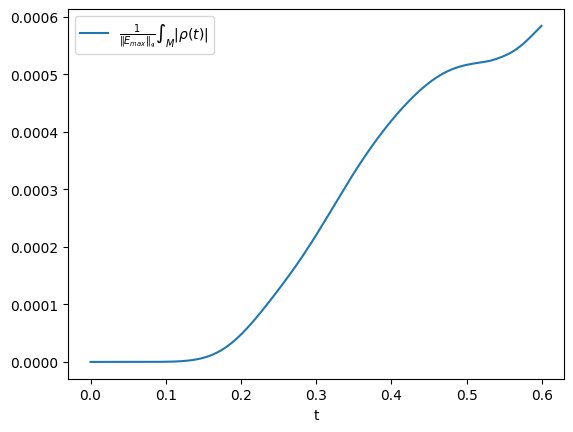

In [15]:
obs_proc = lambda obs_: obs_/Emax

fig = plt.figure()
ax = fig.add_subplot()

#plot_data = folder_dicts[i]["obs"][obs_name]
plot_data = obs_proc(np.array(dq))
#print(plot_data)
graph = ax.plot([i*dt for i in range(len(plot_data))], plot_data, label=r"$\frac{1}{\|E_{max} \|_{\mathfrak{g}}}\int_M |\rho(t)|$")

ax.set_xlabel(r"t")
#ax.set_ylabel(r"$\frac{1}{|E_{max}^\prime|}\int_M |\rho(t)|$")

ax.legend()


plotname = f"grho_t_n_{ne}_order_{order}_dt_{dt}_h_{1./ne}_scale{scale}"

plotname += ".pdf"
print(f"plotname: {plotname}")

plt.savefig(f"{figfolder_name}/{plotname}", format='pdf')

plotname: rhomgrho_t_n_40_order_6_dt_0.0005_h_0.025_scale0.001.pdf


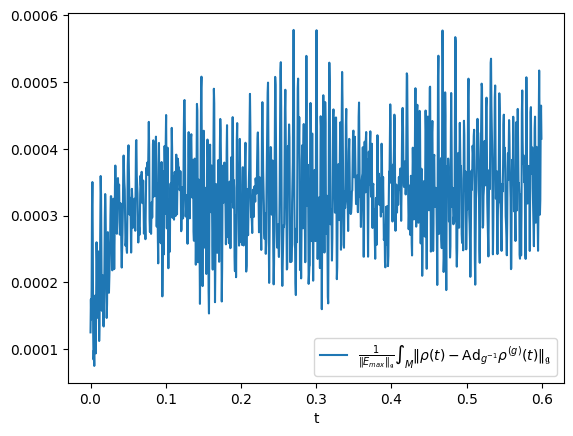

In [18]:
obs_proc = lambda obs_: obs_/Emax

fig = plt.figure()
ax = fig.add_subplot()

#plot_data = folder_dicts[i]["obs"][obs_name]
plot_data = obs_proc(np.array(dqmdqg))
#print(plot_data)
graph = ax.plot([i*dt for i in range(len(plot_data))], plot_data, label=r"$\frac{1}{\|E_{max} \|_{\mathfrak{g}}}\int_M \|\rho(t) - \mathrm{Ad}_{g^{-1}} \rho^{(g)}(t) \|_{\mathfrak{g}}$")

ax.set_xlabel(r"t")
#ax.set_ylabel(r"$\frac{1}{|E_{max}^\prime|}\int_M |\rho(t)|$")

ax.legend()


plotname = f"rhomgrho_t_n_{ne}_order_{order}_dt_{dt}_h_{1./ne}_scale{scale}"

plotname += ".pdf"
print(f"plotname: {plotname}")

plt.savefig(f"{figfolder_name}/{plotname}", format='pdf')

In [ ]:
q_plot_filename = f"C_n{ne}_dt{dt}_order{order}_h_{1./ne}_scale{scale}"

#plt.savefig(f"{figfolder_name}/{q_plot_filename}.png")

with open(f"{figfolder_name}/{q_plot_filename}.json", "w") as f:
    json.dump(dq, f, indent=2)

In [ ]:
q_plot_filename = f"gC_n{ne}_dt{dt}_order{order}_h_{1./ne}_scale{scale}"

#plt.savefig(f"{figfolder_name}/{q_plot_filename}.png")

with open(f"{figfolder_name}/{q_plot_filename}.json", "w") as f:
    json.dump(dqg, f, indent=2)

In [ ]:
q_plot_filename = f"gCmC_n{ne}_dt{dt}_order{order}_h_{1./ne}_scale{scale}"

#plt.savefig(f"{figfolder_name}/{q_plot_filename}.png")

with open(f"{figfolder_name}/{q_plot_filename}.json", "w") as f:
    json.dump(dqmdqg, f, indent=2)